In [66]:
import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import corner
import corner
import time 

In [67]:
'''
MCMC fitting template. 
This template fits a 1-d gaussian, if you 
figure out how to use it for more complicated distributions
I'd appreciate if you let me know :)
banados@mpia.de
'''
np.random.seed(0)
#First let's create a gaussian data

#data = np.random.normal(loc=8, scale=.3, size=1000)
#plt.hist(data, bins = np.linspace(data.min(), data.max(), 20))
file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
print planet_systems
planet_sys = "Sys_2128_1e8.csv"
data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"+planet_sys, index_col = 0)
del data["Unnamed: 0.1"]
del data["runstring"]
data = np.log10(data["t"].values)
plt.hist(data, bins = 20)
sys_name = planet_sys.split("_")[1]




# Then, define the probability distribution that you would like to sample.
def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    #probs = 
    if p[1] <=0:
        return -np.inf#0
    try:
        #probs =  -0.5 * N * np.log(2. * np.pi) - N * np.log(np.abs(p[1])) - 0.5 \
        #                            * np.sum(( (vec - p[0]) / p[1] ) ** 2)
        
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])**2) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
        
    except:
        probs = 0.00
        #int probs, "NANS"
        #return probs
        
    #rint probs
    return probs
    
    
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    #print 
    return prob

                                      

print planet_systems.shape

['Sys_10518_1e8.csv' 'Sys_1174_1e8.csv' 'Sys_12073_1e8.csv'
 'Sys_12840_1e8.csv' 'Sys_13362_1e8.csv' 'Sys_15003_1e8.csv'
 'Sys_15220_1e8.csv' 'Sys_16588_1e8.csv' 'Sys_17641_1e8.csv'
 'Sys_18539_1e8.csv' 'Sys_18651_1e8.csv' 'Sys_19197_1e8.csv'
 'Sys_19591_1e8.csv' 'Sys_19898_1e8.csv' 'Sys_20041_1e8.csv'
 'Sys_2008_1e8.csv' 'Sys_2010_1e8.csv' 'Sys_20620_1e8.csv'
 'Sys_20972_1e8.csv' 'Sys_2105_1e8.csv' 'Sys_2128_1e8.csv'
 'Sys_21872_1e8.csv' 'Sys_22032_1e8.csv' 'Sys_22_1e8.csv'
 'Sys_22998_1e8.csv' 'Sys_23005_1e8.csv' 'Sys_23975_1e8.csv'
 'Sys_24008_1e8.csv' 'Sys_24013_1e8.csv' 'Sys_24017_1e8.csv'
 'Sys_24248_1e8.csv' 'Sys_24346_1e8.csv' 'Sys_24453_1e8.csv'
 'Sys_24576_1e8.csv' 'Sys_24631_1e8.csv' 'Sys_24705_1e8.csv'
 'Sys_24763_1e8.csv' 'Sys_24824_1e8.csv' 'Sys_24930_1e8.csv'
 'Sys_2612_1e8.csv' 'Sys_3000_1e8.csv' 'Sys_3898_1e8.csv' 'Sys_42_1e8.csv'
 'Sys_4641_1e8.csv' 'Sys_4753_1e8.csv' 'Sys_5505_1e8.csv'
 'Sys_5958_1e8.csv' 'Sys_67_1e8.csv' 'Sys_7341_1e8.csv' 'Sys_7431_1e8.csv'
 'Sys_8

In [68]:
#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
#planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems
#planet_sys = "Sys_24576_1e8.csv"

#data.head()

nwalkers = 20
ndim = 2
iterations = 1000

#store all the mean and  sigma in one large array, and then plot it all at the very end,
#since there are 48 systems, and 20*1000 samples per system, the final data array will be 960 000 long.
sample_size = nwalkers*iterations*planet_systems.shape[0]
all_walker_samples=np.zeros((int(sample_size), 4)) # add an extra clumn for the system index, and one for iteration number in for loop 
#mean_samples = np.zeros()

values = np.zeros((planet_systems.shape[0], 6), dtype=str)
info = pd.DataFrame(values, columns=["ID", "Probability", "Mean", "Sigma", "Mean_Error", "Sigma_Error"])
info.head()



for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"+planet_sys, index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    #print data.shape
    data = np.log10(data["t"].values)
    sys_name = planet_sys.split("_")[1]
    print sys_name

    
   

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
    
    # Run 200 steps as a burn-in.
    #print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()
    
    print "Running MCMC ...",
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, iterations, rstate0=jj)
    end = time.time()
    print "Done at ...", (end - start), "seconds." 
    #af = sampler.acceptance_fraction
    #print "Mean acceptance fraction:", np.mean(af)
    

    #Determine the best mean and sigma
    maxprob_indice = np.argmax(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)
    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]
    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )


    '''
    ##PLOT SAMPLING SPACE
    fig = plt.figure(figsize=(15, 8))
    ax =fig.add_subplot("121")
    ax2 = fig.add_subplot("122")
    ax.hist(mean_samples, 100)
    ax.set_title("Samples for Mean - Optimal at " + str("{0:.4f}".format(mean_fit))+ " + "+ str("{0:.4f}".format(mean_std)))
    ax2.set_title("Samples for Sigma - Optimal at " + str("{0:.4f}".format(sigma_fit))+ " + "+ str("{0:.4f}".format(sigma_std)))
    ax2.hist(sigma_samples,  bins = np.linspace(np.min(np.abs(sigma_samples)), np.max(sigma_samples), 100))
    fig.suptitle("Parameters for System "+sys_name)
    #fig.savefig("../../MLstability/Figures/MCMCFigures/Parameters_"+sys_name, bbox_inches='tight')
    plt.close(fig)
    '''
    
    
    
    ##PLOT CORNER PLOT
    probability = -np.log(2*np.pi)/2. - np.log(sigma_fit**2.)/2.-(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    '''
    print samples.shape
    fig = plt.figure(figsize=(12, 12))
    fig = corner.corner(samples, labels=["$m$", "$s$"],  figsize = (12, 12))
    fig.suptitle("MCMC fit for Mu and Sigma for System "+ sys_name + " with Probability of "+ str("{:.4f}".format(np.exp(probability))))
    #fig.savefig("../../MLstability/Figures/MCMCFigures/System_"+sys_name, bbox_inches='tight')
    plt.close(fig)
    '''
       
    #SAVE INFO OF INTEREST
    if probability>1:
        info.loc[jj] = [sys_name]+[np.inf]+[mean_fit, sigma_fit] + [np.inf]*2

    else:
        info.loc[jj] = [sys_name, np.exp(probability), mean_fit, sigma_fit, mean_std, sigma_std]
    print sys_name , probability, np.exp(probability),"\n"
    

    #save all the wallker values to be plotted later on
    #the thrid column in the system name
    #the fourth column is giving an index number, used for creating the custom color bar
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers), :2] = samples[:,:]
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers):,2] = sys_name
    all_walker_samples[(jj)*int(iterations*nwalkers):(jj+1)*int(iterations*nwalkers):,3] = jj

    #break

10518
Running MCMC ... Done at ... 1.0043451786 seconds.
10518 -9.50377589547 7.45697301267e-05 

1174
Running MCMC ... Done at ... 0.986623048782 seconds.
1174 -8.91831333249 0.000133913922678 

12073
Running MCMC ... Done at ... 0.990790843964 seconds.
12073 -9.70562872033 6.09395163869e-05 

12840
Running MCMC ... Done at ... 0.993603944778 seconds.
12840 -9.9525239439 4.76073239581e-05 

13362
Running MCMC ... Done at ... 0.997319221497 seconds.
13362 -9.64029040085 6.50541602208e-05 

15003
Running MCMC ... Done at ... 0.990828037262 seconds.
15003 -9.37286128941 8.49998310255e-05 

15220
Running MCMC ... Done at ... 0.993399858475 seconds.
15220 -9.41645687342 8.13738269081e-05 

16588
Running MCMC ... Done at ... 0.993427038193 seconds.
16588 -9.57679150848 6.93190007344e-05 

17641
Running MCMC ... Done at ... 0.997740030289 seconds.
17641 -9.28901457788 9.24341020245e-05 

18539
Running MCMC ... Done at ... 0.999721050262 seconds.
18539 -9.26968610862 9.42380897223e-05 

18651

In [69]:
info

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error
0,10518,7.45697e-05,6.46334,0.42928,0.0137836,0.00955613
1,1174,0.000133914,5.25945,0.238805,0.00775013,0.00525995
2,12073,6.09395e-05,4.52124,0.523978,0.0165151,0.0116984
3,12840,4.76073e-05,4.70594,0.611376,0.0196651,0.0138068
4,13362,6.50542e-05,2.0852,0.382739,0.0124772,0.00876803
5,15003,8.49998e-05,6.74903,0.45756,0.0145967,0.0102664
6,15220,8.13738e-05,5.80971,0.364427,0.0116223,0.00825858
7,16588,6.9319e-05,6.62712,0.461296,0.0144236,0.0103914
8,17641,9.24341e-05,5.44976,0.390168,0.0124051,0.00848419
9,18539,9.42381e-05,6.81684,0.524183,0.0168521,0.0119535


(1060000, 4)
53
256


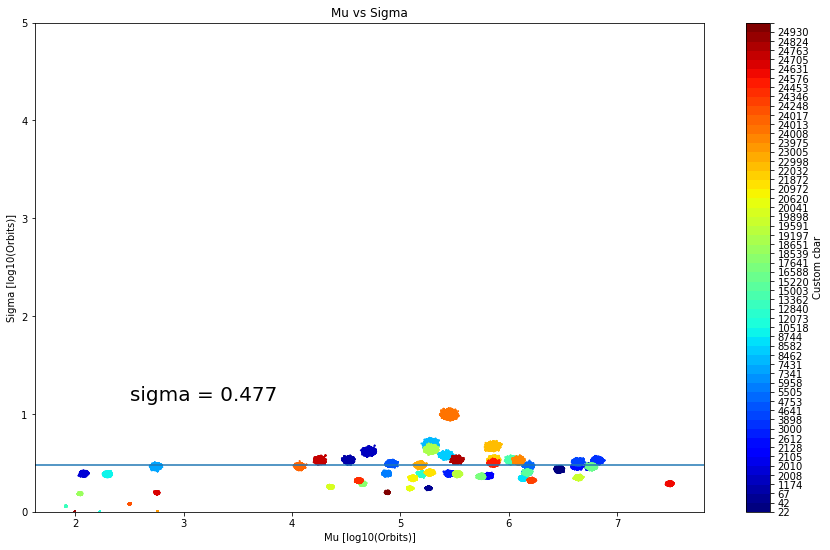

In [76]:
print all_walker_samples.shape
fig = plt.figure(figsize = (15,9))
ax = fig.add_subplot("111")

# the number of labels
N = len(planet_systems)
# define the colormap
cmap = plt.cm.jet
print N
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
#scat = ax.scatter(x,y,c=tag,s=np.random.randint(100,500,N),cmap=cmap,     norm=norm)
print len(cmaplist)

#ax.errorbar(info["Mean"].values, info["Sigma"].values, 
#            yerr =info["Sigma_Error"], xerr = info["Mean_Error"], fmt='o')
#'''
scat = ax.scatter(all_walker_samples[:,0], all_walker_samples[:,1], c = all_walker_samples[:,3], 
                 cmap = cmap, norm = norm, s = 1) #mean vs sigma

# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Custom cbar')
cb.ax.set_yticklabels(np.unique(all_walker_samples[:,2].astype(int)))
#'''
ax.set_title('Mu vs Sigma')
ax.set_ylabel("Sigma [log10(Orbits)]")
ax.set_xlabel("Mu [log10(Orbits)]")
ax.set_ylim([0,5])
ax.axhline(y= 0.477)
plt.annotate("sigma = 0.477",
             xycoords='figure pixels', xy=(130, 150), fontsize = 20)
fig.savefig("../Figures/MCMCFigures/Mean vs Dispersion MCMC fits.png", bbox_inches='tight' )
plt.show()

#colors = [int(i % len(planet_systems)) for i in all_walker_samples[:,2]]
#plt.show()

In [78]:
info
#info[info["Mean"]<3]
info.to_csv("../Figures/MCMCFigures/ProbabilityTable_Fixed.csv")


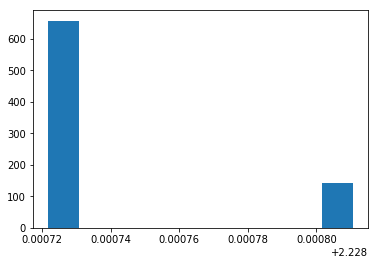

Burning in ...
Running MCMC ...
Done at ... 9.52110600471 seconds.
Mean acceptance fraction: 0.44075
Estimated parameters: mean, sigma = 2.228738, 0.000034
parameters' error: mean, sigma = 0.000001, 0.000001
0.902229240589 2.4650922743


In [96]:

weird_data = pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/Sys_2128_1e8.csv")
data = np.log10(weird_data["t"])
plt.hist(data)
plt.show()
ndim = 2
nwalkers = 20

# Choose an initial set of positions for the walkers.
p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
#print "State", sampler.random_state

# Run 200 steps as a burn-in.
print "Burning in ..."
pos, prob, state = sampler.run_mcmc(p0, 200)

# Reset the chain to remove the burn-in samples.
sampler.reset()

# Starting from the final position in the burn-in chain, sample for 1000
# steps. (rstate0 is the state of the internal random number generator)
print "Running MCMC ..."
start = time.time()
pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=jj)
end = time.time()
print "Done at ...", (end - start), "seconds." 
# Print out the mean acceptance fraction. In general, acceptance_fraction
# has an entry for each walker so, in this case, it is a 250-dimensional
# vector.
af = sampler.acceptance_fraction
print "Mean acceptance fraction:", np.mean(af)


maxprob_indice = np.argmax(prob)
mean_fit, sigma_fit = pos[maxprob_indice]
sigma_fit = np.abs(sigma_fit)
print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)

mean_samples = sampler.flatchain[:,0]
sigma_samples = sampler.flatchain[:,1]

mean_std = mean_samples.std()
sigma_std =np.std(np.abs(sigma_samples) )

print "parameters' error: mean, sigma = %f, %f" % (mean_std, sigma_std)




##PLOT CORNER PLOT
probability = -np.log(2*np.pi)/2. - np.log(sigma_fit**2.)/2.-(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)



print probability, np.exp(probability)
#rint -np.log(2*np.pi)/2.
#print - np.log(sigma_fit**2.)/2.
#print -(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
#prob = print prob, np.exp(prob)
#print -np.log(2*np.pi)/2.- np.log(sigma_fit**2.)/2. -(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
#break
#info

In [97]:
"{0:.4f}".format(31214.41)
print planet_systems.shape, info.shape
#info.to_csv
#info.to_csv("../Figures/MCMCFigures/ProbabilityTable_Fixed.csv")
info

(48,) (48, 6)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error
0,10518,3.89043e-05,6.47022,0.436671,0.0139549,0.00991533
1,1174,5.3794e-05,5.25678,0.239669,0.00765968,0.00529381
2,12073,2.28341e-05,4.52347,0.524005,0.0163238,0.0118572
3,12840,2.07945e-05,4.70189,0.616463,0.0196314,0.0132143
4,13362,2.7468e-05,2.07702,0.385503,0.0122768,0.00874218
5,15003,3.41478e-05,6.74546,0.458778,0.01458,0.0104945
6,15220,3.80951e-05,5.81145,0.368722,0.0117968,0.00779021
7,16588,2.52255e-05,6.6295,0.460635,0.0149262,0.0100008
8,17641,2.7306e-05,5.45029,0.385289,0.0126199,0.00880936
9,18539,3.01496e-05,6.8104,0.518659,0.016615,0.0117145


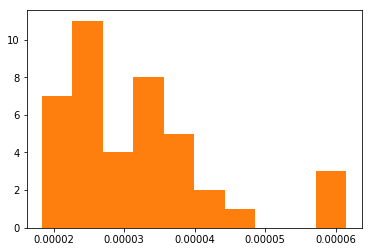

In [91]:
prob_vals = np.nan_to_num(info["Probability"].values)
#info.hist("Probability")
plt.hist(prob_vals)
plt.show()

In [ ]:
#repeat with one system, and plot how the error changes as you change how many points you sample

In [34]:
#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
#planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems
#planet_sys = "Sys_24576_1e8.csv"

#data.head()
#plt.hist(data, bins = 20)


vals = np.linspace(100,1000,19)
overall_mean = np.zeros_like(vals)
print overall_mean.shape
overall_sigma = np.zeros_like(vals)
mean_error = np.zeros_like(vals)
sigma_error = np.zeros_like(vals)

print vals
nwalkers = 250

for j,val in enumerate(vals):
    data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/Sys_10518_1e8.csv", index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = np.log10(data["t"].values)
    data= data[:int(val)]
    sys_name = planet_sys.split("_")[1]
    print sys_name, data.shape
    # We'll sample a Gaussian which has 2 parameters: mean and sigma...
    ndim = 2
    
    # We'll sample with 250 walkers. (nwalkers must be an even number)

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

    # Initialize the sampler with the chosen specs.
    #The "a" parameter controls the step size, the default is a=2,
    #but in this case works better with a=4 see below or page 10 in the paper
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)

    # Run 200 steps as a burn-in.
    print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()

    # Starting from the final position in the burn-in chain, sample for 1000
    # steps. (rstate0 is the state of the internal random number generator)
    print "Running MCMC ..."
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
    end = time.time()
    print "Done at ...", (end - start), "seconds." 
  
    
    maxprob_indice = np.argmax(prob)
    print "Max prob", np.max(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)

    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]

    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )
    #sigma_samples.std()

    print "parameters' error: mean, sigma = %f, %f" % (mean_std, sigma_std)

  
    print mean_fit, sigma_fit, j
    overall_mean[j]= mean_fit
    
    overall_sigma[j] = sigma_fit
    mean_error[j] = mean_std
    sigma_error[j]= sigma_std
    x = np.arange(pos.shape[0])
    print x.shape, pos.shape
    #plt.plot(x, pos[:, 0])
    #plt.show()
    #plt.figure()
    #plt.plot(x ,pos[:, 1])
    #plt.show()
    #break
    
    #print log_prob_normed(mean_fit-1, sigma_fit-1, data)


(19,)
[  100.   150.   200.   250.   300.   350.   400.   450.   500.   550.
   600.   650.   700.   750.   800.   850.   900.   950.  1000.]
10518 (100,)
Burning in ...
Running MCMC ...
Done at ... 6.91495800018 seconds.
Max prob -52.0144564827
Estimated parameters: mean, sigma = 6.528864, 0.407383
parameters' error: mean, sigma = 0.041472, 0.029750
6.52886422293 0.407382978054 0
(250,) (250, 2)
10518 (150,)
Burning in ...
Running MCMC ...
Done at ... 7.38945889473 seconds.
Max prob -76.9158398522
Estimated parameters: mean, sigma = 6.491855, 0.401857
parameters' error: mean, sigma = 0.033380, 0.023915
6.49185544331 0.401856848521 1
(250,) (250, 2)
10518 (200,)
Burning in ...
Running MCMC ...
Done at ... 7.43438982964 seconds.
Max prob -106.629933233
Estimated parameters: mean, sigma = 6.485075, 0.411897
parameters' error: mean, sigma = 0.029208, 0.020865
6.48507455163 0.411896564026 2
(250,) (250, 2)
10518 (250,)
Burning in ...
Running MCMC ...
Done at ... 7.57039880753 seconds.
Max 

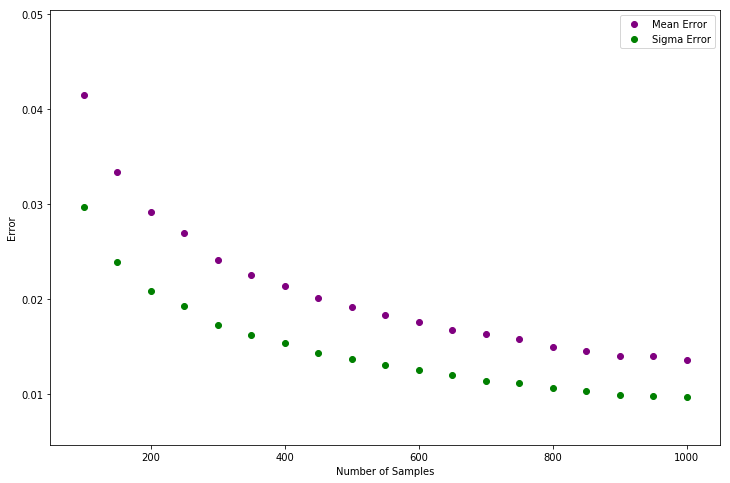

In [36]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
#ax.scatter(vals, overall_mean)
#ax.scatter(vals, overall_sigma)
ax.scatter(vals, mean_error, color = "purple", label = "Mean Error")
ax.scatter(vals, sigma_error, color = "green", label = "Sigma Error")
ax.legend(loc = 0)
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Error")
#fig.savefig("../../MLstability/Figures/MCMCFigures/Error", bbox_inches='tight')
plt.show()

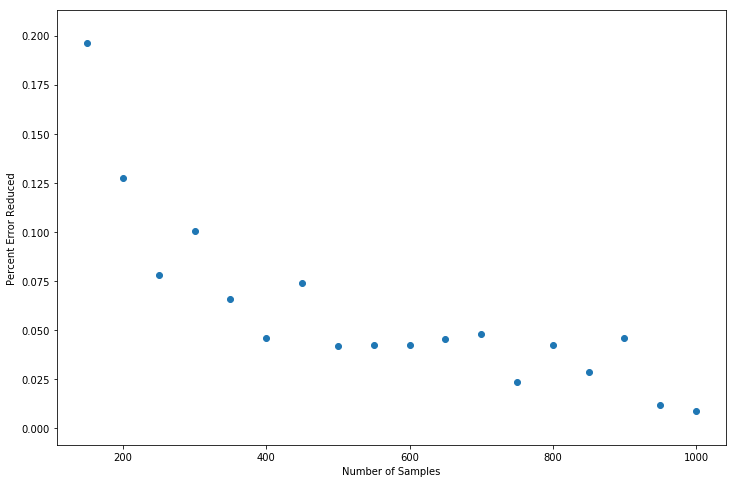

In [37]:
#make a plot of the reduction of error for each step 
#error reduced = (err2 - err1)/err1
fig = plt.figure(figsize=(12, 8))
sig_error_reduces = np.zeros(vals.shape[0]-1)
for i in range(sig_error_reduces.shape[0]):
    sig_error_reduces[i] = (sigma_error[i] - sigma_error[i+1]) / sigma_error[i]
plt.scatter(vals[1:], sig_error_reduces)
plt.ylabel("Percent Error Reduced")
plt.xlabel("Number of Samples")
#fig.savefig("../../MLstability/Figures/MCMCFigures/PercentErrorReduced.png", bbox_inches='tight')
plt.show()

In [39]:
np.logspace(1, 7, 20)

array([  1.00000000e+01,   2.06913808e+01,   4.28133240e+01,
         8.85866790e+01,   1.83298071e+02,   3.79269019e+02,
         7.84759970e+02,   1.62377674e+03,   3.35981829e+03,
         6.95192796e+03,   1.43844989e+04,   2.97635144e+04,
         6.15848211e+04,   1.27427499e+05,   2.63665090e+05,
         5.45559478e+05,   1.12883789e+06,   2.33572147e+06,
         4.83293024e+06,   1.00000000e+07])

In [63]:
#try logspace with generated gaussian
np.random.seed(0)
#First let's create a gaussian data
data = np.random.normal(loc=8, scale=.3, size=int(1e7))
print data.shape
vals =  np.logspace(1, 6, 15)

#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
#planet_systems = np.loadtxt(file_path+"Order.txt", dtype = str)
#print planet_systems
#planet_sys = "Sys_24576_1e8.csv"

#data.head()
#plt.hist(data, bins = 20)

(10000000,)


In [64]:
def run_error_analysis(vals, total_data):
    #np.linspace(100,1000,19)
    overall_mean = np.zeros_like(vals)
    print overall_mean.shape
    overall_sigma = np.zeros_like(vals)
    mean_error = np.zeros_like(vals)
    sigma_error = np.zeros_like(vals)

    print vals
    nwalkers = 20


    for j,val in enumerate(vals):
        #print data.shape, 
        data= total_data[:int(val)]
        print val, data.shape
        #sys_name = planet_sys.split("_")[1]
        #print sys_name, data.shape
        # We'll sample a Gaussian which has 2 parameters: mean and sigma...
        ndim = 2

        # We'll sample with 250 walkers. (nwalkers must be an even number)

        # Choose an initial set of positions for the walkers.
        p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

        # Initialize the sampler with the chosen specs.
        #The "a" parameter controls the step size, the default is a=2,
        #but in this case works better with a=4 see below or page 10 in the paper
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)

        # Run 200 steps as a burn-in.
        #print "Burning in ..."
        pos, prob, state = sampler.run_mcmc(p0, 200)

        # Reset the chain to remove the burn-in samples.
        sampler.reset()

        # Starting from the final position in the burn-in chain, sample for 1000
        # steps. (rstate0 is the state of the internal random number generator)
        #print "Running MCMC ..."
        start = time.time()
        pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
        end = time.time()
        print "Done at ...", (end - start), "seconds." 


        maxprob_indice = np.argmax(prob)
        #print "Max prob", np.max(prob)
        mean_fit, sigma_fit = pos[maxprob_indice]
        sigma_fit = np.abs(sigma_fit)
        #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)

        mean_samples = sampler.flatchain[:,0]
        sigma_samples = sampler.flatchain[:,1]

        mean_std = mean_samples.std()
        sigma_std =np.std(np.abs(sigma_samples) )
        #sigma_samples.std()

        #print "parameters' error: mean, sigma = %f, %f" % (mean_std, sigma_std)


        #print mean_fit, sigma_fit, j
        overall_mean[j]= mean_fit

        overall_sigma[j] = sigma_fit
        mean_error[j] = mean_std
        sigma_error[j]= sigma_std
        x = np.arange(pos.shape[0])
        #print x.shape, pos.shape
        print "\n"
        #print log_prob_normed(mean_fit-1, sigma_fit-1, data)
    return overall_mean, overall_sigma, mean_error, sigma_error


In [65]:
overall_mean, overall_sigma, mean_error, sigma_error = run_error_analysis(vals, data)

(15,)
[  1.00000000e+01   2.27584593e+01   5.17947468e+01   1.17876863e+02
   2.68269580e+02   6.10540230e+02   1.38949549e+03   3.16227766e+03
   7.19685673e+03   1.63789371e+04   3.72759372e+04   8.48342898e+04
   1.93069773e+05   4.39397056e+05   1.00000000e+06]
10.0 (10,)
Done at ... 0.776919841766 seconds.


22.7584592607 (22,)
Done at ... 0.792902946472 seconds.


51.7947467923 (51,)
Done at ... 0.816807031631 seconds.


117.876863479 (117,)
Done at ... 0.816536188126 seconds.


268.269579528 (268,)
Done at ... 0.864029884338 seconds.


610.540229659 (610,)
Done at ... 0.924199819565 seconds.


1389.49549437 (1389,)
Done at ... 1.03450107574 seconds.


3162.27766017 (3162,)
Done at ... 1.23071885109 seconds.


7196.85673001 (7196,)
Done at ... 1.69460201263 seconds.


16378.9370695 (16378,)
Done at ... 2.73704385757 seconds.


37275.9372031 (37275,)
Done at ... 5.23797011375 seconds.


84834.2898244 (84834,)
Done at ... 10.1045470238 seconds.


193069.772888 (193069,)
Done at ...

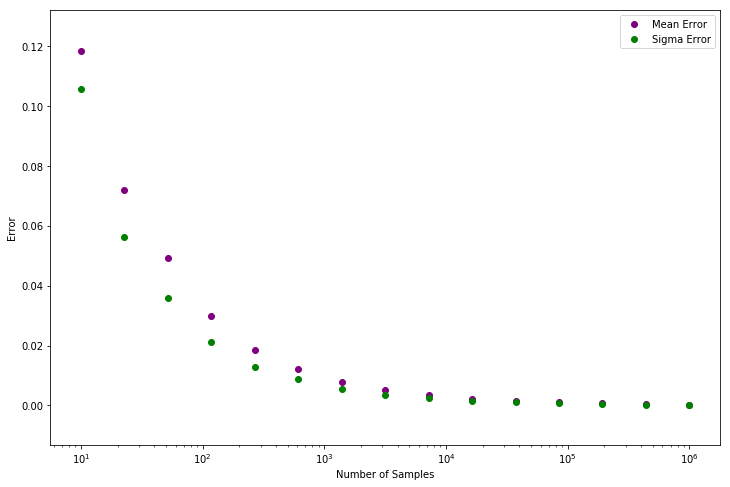

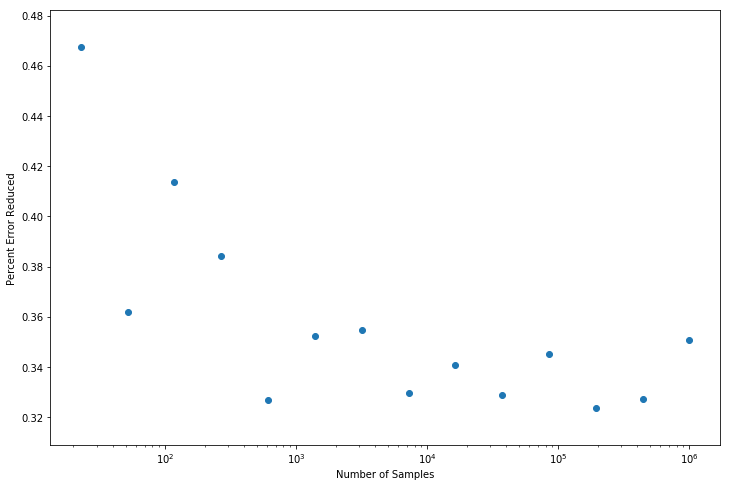

In [70]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
#ax.scatter(vals, overall_mean)
#ax.scatter(vals, overall_sigma)
ax.scatter(vals, mean_error, color = "purple", label = "Mean Error")
ax.scatter(vals, sigma_error, color = "green", label = "Sigma Error")
ax.legend(loc = 0)
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Error")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/Error", bbox_inches='tight')
plt.show()

#make a plot of the reduction of error for each step 
#error reduced = (err2 - err1)/err1
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
sig_error_reduces = np.zeros(vals.shape[0]-1)
for i in range(sig_error_reduces.shape[0]):
    sig_error_reduces[i] = (sigma_error[i] - sigma_error[i+1]) / sigma_error[i]
ax.scatter(vals[1:], sig_error_reduces)
ax.set_ylabel("Percent Error Reduced")
ax.set_xlabel("Number of Samples")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/PercentErrorReduced.png", bbox_inches='tight')
plt.show()

In [75]:
vals =  np.logspace(1, 4, 15)
print vals
overall_mean, overall_sigma, mean_error, sigma_error = run_error_analysis(vals, data)


[    10.             16.37893707     26.82695795     43.93970561
     71.9685673     117.87686348    193.06977289    316.22776602
    517.94746792    848.34289824   1389.49549437   2275.84592607
   3727.59372031   6105.40229659  10000.        ]
(15,)
[    10.             16.37893707     26.82695795     43.93970561
     71.9685673     117.87686348    193.06977289    316.22776602
    517.94746792    848.34289824   1389.49549437   2275.84592607
   3727.59372031   6105.40229659  10000.        ]
10.0 (10,)
Done at ... 0.786319971085 seconds.


16.3789370695 (16,)
Done at ... 0.790235996246 seconds.


26.8269579528 (26,)
Done at ... 0.804243087769 seconds.


43.9397056076 (43,)
Done at ... 0.853454828262 seconds.


71.9685673001 (71,)
Done at ... 0.867842912674 seconds.


117.876863479 (117,)
Done at ... 0.866768836975 seconds.


193.069772888 (193,)
Done at ... 0.905980825424 seconds.


316.227766017 (316,)
Done at ... 0.92834687233 seconds.


517.947467923 (517,)
Done at ... 0.957716941833

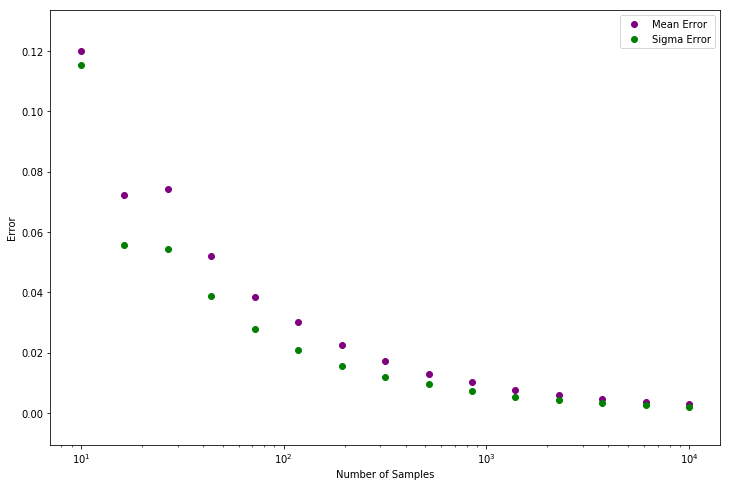

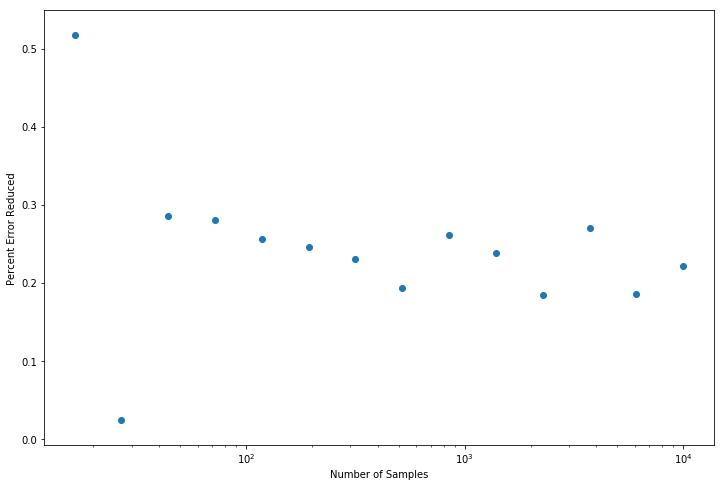

In [77]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
#ax.scatter(vals, overall_mean)
#ax.scatter(vals, overall_sigma)
ax.scatter(vals, mean_error, color = "purple", label = "Mean Error")
ax.scatter(vals, sigma_error, color = "green", label = "Sigma Error")
ax.legend(loc = 0)
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Error")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/Error", bbox_inches='tight')
plt.show()

#make a plot of the reduction of error for each step 
#error reduced = (err2 - err1)/err1
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
sig_error_reduces = np.zeros(vals.shape[0]-1)
for i in range(sig_error_reduces.shape[0]):
    sig_error_reduces[i] = (sigma_error[i] - sigma_error[i+1]) / sigma_error[i]
ax.scatter(vals[1:], sig_error_reduces)
ax.set_ylabel("Percent Error Reduced")
ax.set_xlabel("Number of Samples")
ax.set_xscale("log")

#fig.savefig("../../MLstability/Figures/MCMCFigures/PercentErrorReduced.png", bbox_inches='tight')
plt.show()